# Tutorial: Sub-Riemannian geometry on the Heisenberg group

Lead author: Morten Pedersen.

## Setup

In [5]:
import os
import subprocess

%matplotlib notebook

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(geomstats_gitroot_path[:-1])

print("Working directory: ", os.getcwd())

Working directory:  /home/mpederse/Documents/Code/geomstats


We set the geomstats backend to be 'autograd' and import this backend, along with the 2 main modules we will use,

In [6]:
os.environ['GEOMSTATS_BACKEND'] = 'autograd'

import geomstats.backend as gs
import geomstats

from geomstats.geometry.sub_riemannian_metric import *
from geomstats.geometry.heisenberg import *

We import modules for plotting,

In [7]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

## The Heisenberg group

We instantiate the 3D heisenberg group, 

In [8]:
heis = HeisenbergVectors()

'heis' is an object representing a manifold, without any sub-Riemannian structure associated to it. 

In geomstats, a sub-Riemannian structure is constructed via the SubRiemannianMetric-class. 
We now instantiate a SubRiemannianMetric corresponding to the heisenberg group. 

In geomstats, a sub-Riemannian metric can be instantiated by supplying either 

- a function which at an input point outputs the matrix representing the cometric, or
- a function which at an input point outputs a matrix whose columns are frame-vectors spanning the distribution at that point. This frame is then implicitly assumed to be orthonormal, so it determines both the distribution and the metric on the tangent bundle.

## Defining the Heisenberg sub-Riemannian structure via a frame-field

We will construct the sub-Riemannian Heisenberg group by supplying a frame-function. Mathematically, we represent the distribution $\Delta$ in a standard way; at the point  $p \in heis$ the distribution is $$\Delta_p = \text{span}(F_X(p), F_Y(p)),$$ where $F_X = L^{\star}_p(X)$, $F_Y = L^{\star}_p(Y)$ and $X = (1,0,0)$, $Y=(0,1,0)$.  So e.g. $F_X$ is the tangent left translation to point $p$ of the standard basis vector X in the Lie-algebra. In geomstats, this can be done concisely as follows,

In [9]:
def heis_frame(point):

    translations = heis.jacobian_translation(point)
    if len(translations.shape)==3:
        return translations[:, :, 0:2]
    return translations[:, 0:2]
    

Given the frame, we now instantiate the sub-Riemannian metric for the Heisenberg group

In [10]:
heis_sr = SubRiemannianMetric(dim=3, dist_dim=2, frame=heis_frame)

We can illustrate the distribution by plotting the frame-vectors along a line:

<IPython.core.display.Javascript object>


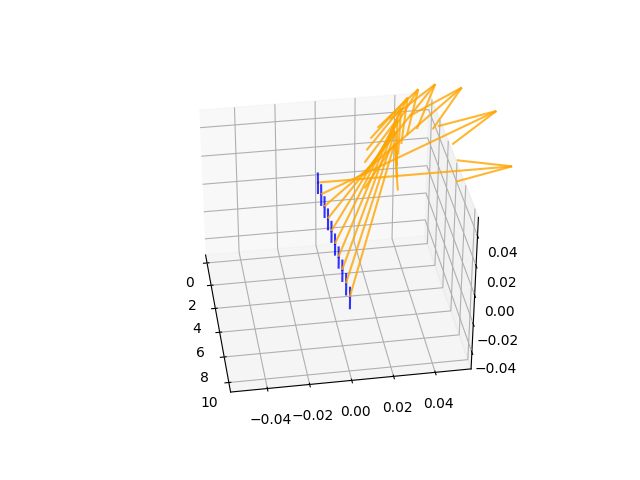

In [11]:
line = gs.array([k*gs.array([1., 1., 1.]) for k in gs.linspace(0,10,10)])
line = gs.array([k*gs.array([1., 0., 0.]) for k in gs.linspace(0,10,10)])

quiver_length = 0.1


fig1 = plt.figure()
ax  = plt.axes(projection='3d')

for i in range(line.shape[0]):
        point = line[i,:]
        frame_at_point = heis_sr.frame(point)
        
        frame1 = frame_at_point[:, 1]
        frame2 = frame_at_point[:, 0]

        ax.quiver(point[0], point[1], point[2],
                  frame1[0], frame1[1], frame1[2],
                  length = quiver_length, normalize = True, color = 'orange',alpha=0.8,
                  linestyle = '-')
        ax.quiver(point[0], point[1], point[2],
                  frame2[0], frame2[1], frame2[2],
                  length = quiver_length, normalize = True, color = 'blue',alpha=0.8,
                  linestyle = '-')

Everything is now set up to generate sub-Riemannian geodesics. A sub-Riemannian geodesic on a manifold $M$ is determined by an initial point $p \in M$ and an initial cotangent $\lambda \in T_p M$.

In [12]:
base_point = gs.array([0., 0., 0.])
initial_cotangent = gs.array([1., 1., 1.])

times = gs.linspace(0., 10., 50)

path = heis_sr.geodesic(initial_point=base_point,
                        initial_cotangent_vec=initial_cotangent,
                        n_steps=1000)

path_1_1 = path(times)


<IPython.core.display.Javascript object>


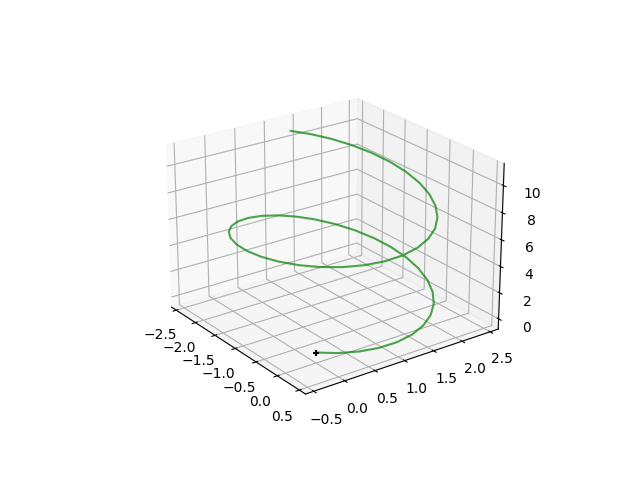

In [13]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

fig1 = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(0, 0, 0, marker='+', color='black')

ax.plot3D(path_1_1[:, 0],
          path_1_1[:, 1],
          path_1_1[:, 2],
          '-',
          linewidth=1.5,
          markersize=0,
          marker='.',
          color='green',
          alpha=0.7)

plt.show()


## Sub-Riemannian structures as limits of Riemannian structures

If the distribution $\Delta$ is of the same dimension as the manifold at every point, the structure is actually Riemannian. In geomtats, if the manifold is $n$-dimensional and we pass a frame function with $n$ linearly independent vectors at every point, this will generate the Riemannian structure with a metric that makes these vectors orthonormal at every point. 

For the heisenberg group, we can use the frame given by left-translation of the standard basis in the Lie algebra, $$\{F_X(p), F_Y(p), \epsilon\cdot F_Z(p)\},$$ where $\epsilon \in [0,1]$. For $\epsilon=0$ the geodesics will be those of the standard Heisenberg group. For $\epsilon = 1$ the geodesics will be those of the left-invariant Riemannian metric which on the algebra is simply the euclidean metric.


In [14]:
def heis_frame_riemannian(point, epsilon):

    frame_matrix = heis.jacobian_translation(point)

    scale_matrix = gs.array([gs.ones((3,)), gs.ones((3,)), gs.ones((3,))*epsilon]).T

    return  gs.einsum('...ij,...ij -> ...ij', frame_matrix, scale_matrix)

heis_epsilon_1 = SubRiemannianMetric(dim=3, dist_dim=2, frame=lambda point : heis_frame_riemannian(point, 1))
heis_epsilon_0 = SubRiemannianMetric(dim=3, dist_dim=2, frame=lambda point : heis_frame_riemannian(point, 0))


<IPython.core.display.Javascript object>


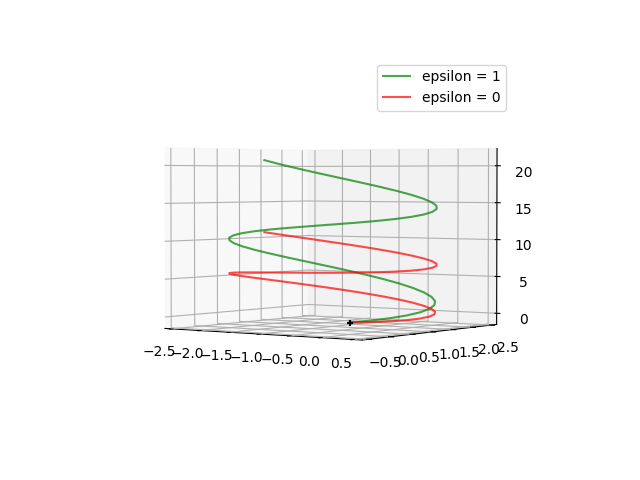

In [15]:
base_point = gs.array([0., 0., 0.])
initial_cotangent = gs.array([1., 1., 1.])

times = gs.linspace(0., 10., 50)

path_epsilon_1 = heis_epsilon_1.geodesic(initial_point=base_point,
                                         initial_cotangent_vec=initial_cotangent,
                                         n_steps=1000)

path_epsilon_0 = heis_epsilon_0.geodesic(initial_point=base_point,
                                         initial_cotangent_vec=initial_cotangent,
                                         n_steps=1000)


path_1 = path_epsilon_1(times)
path_0 = path_epsilon_0(times)

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

fig1 = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(0, 0, 0, marker='+', color='black')

ax.plot3D(path_1[:, 0],
          path_1[:, 1],
          path_1[:, 2],
          '-',
          linewidth=1.5,
          markersize=0,
          marker='.',
          color='green',
          alpha=0.7,
          label='epsilon = 1')

ax.plot3D(path_0[:, 0],
          path_0[:, 1],
          path_0[:, 2],
          '-',
          linewidth=1.5,
          markersize=0,
          marker='.',
          color='red',
          alpha=0.7,
          label='epsilon = 0')

ax.legend()

plt.show()


We see that the spiralling structure is similar for the Riemannian ($\epsilon=1$) and the sub-Riemannian ($\epsilon=0$) geodesics, in fact only their z-coordinates differ. Let's check that the sub-Riemannian geodesic is horizontal wrt. to the distribution $\Delta_p = \text{span}(F_X(p), F_Y(p))$  (i.e. it's tangent vectors lies in $\Delta$), whereas the Riemannian one isn't.

<IPython.core.display.Javascript object>


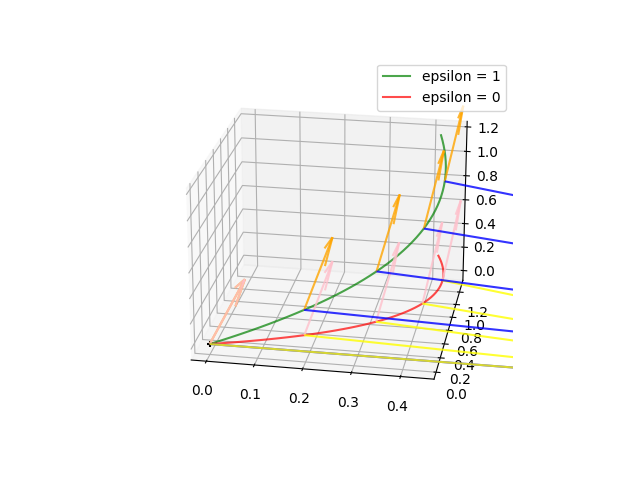

In [16]:
base_point = gs.array([0., 0., 0.])
initial_cotangent = gs.array([1., 1., 1.])

times = gs.linspace(0., 1., 50)

path_epsilon_1 = heis_epsilon_1.geodesic(initial_point=base_point,
                                         initial_cotangent_vec=initial_cotangent)

path_epsilon_0 = heis_epsilon_0.geodesic(initial_point=base_point,
                                         initial_cotangent_vec=initial_cotangent)


path_1 = path_epsilon_1(times)
path_0 = path_epsilon_0(times)

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

fig1 = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(0, 0, 0, marker='+', color='black')

ax.plot3D(path_1[:, 0],
          path_1[:, 1],
          path_1[:, 2],
          '-',
          linewidth=1.5,
          markersize=0,
          marker='.',
          color='green',
          alpha=0.7,
          label='epsilon = 1')

ax.plot3D(path_0[:, 0],
          path_0[:, 1],
          path_0[:, 2],
          '-',
          linewidth=1.5,
          markersize=0,
          marker='.',
          color='red',
          alpha=0.7,
          label='epsilon = 0')

ax.legend()

quiver_length = 1

exp_curve = path_1

for i in range(exp_curve.shape[0]):
    if i % 10 == 0:
        point = exp_curve[i,:]
        frame_at_point = heis_sr.frame(point)
        
        frame1 = frame_at_point[:, 1]
        frame2 = frame_at_point[:, 0]

        ax.quiver(point[0], point[1], point[2],
                  frame1[0], frame1[1], frame1[2],
                  length = quiver_length, normalize = True, color = 'orange',alpha=0.8,
                  linestyle = '-')
        ax.quiver(point[0], point[1], point[2],
                  frame2[0], frame2[1], frame2[2],
                  length = quiver_length, normalize = True, color = 'blue',alpha=0.8,
                  linestyle = '-')


quiver_length = 1

exp_curve = path_0

for i in range(exp_curve.shape[0]):
    if i % 10 == 0:

        point = exp_curve[i,:]
        frame_at_point = heis_sr.frame(point)
        
        frame1 = frame_at_point[:, 1]
        frame2 = frame_at_point[:, 0]

        ax.quiver(point[0], point[1], point[2],
                  frame1[0], frame1[1], frame1[2],
                  length = quiver_length, normalize = True, color = 'pink',alpha=0.8,
                  linestyle = '-')
        ax.quiver(point[0], point[1], point[2],
                  frame2[0], frame2[1], frame2[2],
                  length = quiver_length, normalize = True, color = 'yellow',alpha=0.8,
                  linestyle = '-')

ax.view_init(3, -96)        

plt.show()